## Импорт библиотек

In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Подсоединение к БД

In [2]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

## Запросы к БД

Получаем данные о количестве строк и столбцов в таблице `ldn_listings`:

In [3]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query1 = """
SELECT COUNT(id) AS rows_number
FROM ldn_listings
"""
df1 = ph.read_clickhouse(query1, connection = connection)

query2 = """
SELECT *
FROM ldn_listings
LIMIT 1
"""
df2 = ph.read_clickhouse(query2, connection = connection)

In [7]:
print(df1['rows_number'].iloc[0],"rows")
print(df2.shape[1],"columns")

85207 rows
106 columns


Выгрузка из таблицы данных о цене в зависимости от типа жилья. Необходимые столбцы:
- `price` – цена за ночь,
- `room_type` – тип сдаваемого жилья (доступные варианты: `Entire home/apt`, `Private room`, `Hotel room`, `Shared room`).

In [8]:
query3 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price    
FROM ldn_listings
ORDER BY
    id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query3, connection = connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [9]:
df \
    .groupby('room_type', as_index = False) \
    .quantile(q = 0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [10]:
df \
    .groupby('room_type', as_index = False) \
    .quantile(q = 0.75) \
    .query("room_type == 'Private room'") \
    ['price']

2    70.0
Name: price, dtype: float64

In [11]:
subtable = df \
    .groupby('room_type', as_index = False) \
    .quantile(q = 0.75)

In [12]:
answer_raw = subtable.query("room_type == 'Private room'")['price']
answer_raw

2    70.0
Name: price, dtype: float64

In [13]:
answer_raw.dtypes

dtype('float64')

In [14]:
answer_raw.iloc[0]

70.0

К данным о цене и типе комнаты дополнительно выгрузим данные о рейтинге жилья (`review_scores_rating`). В запросе необходимо будет отфильтровать пустые значения `review_scores_rating` и сконвертировать эту колонку в тип `float32`.

In [15]:
query4 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM
    ldn_listings
WHERE
    review_scores_rating IS NOT NULL
ORDER BY
    id ASC
LIMIT 1000
"""
df4 = ph.read_clickhouse(query4, connection = connection)
df4

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [16]:
df_4_grouping = df4 \
    .groupby('room_type', as_index = False) \
    .agg({'price': 'mean',
          'review_scores_rating': 'mean'}) \
    .sort_values('room_type')
df_4_grouping

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

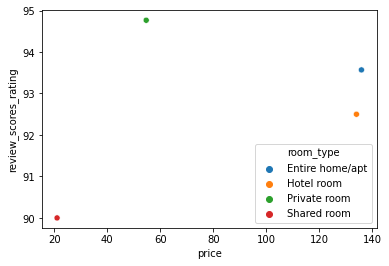

In [17]:
sns.scatterplot(x = 'price',
                y = 'review_scores_rating',
                data = df_4_grouping,
                hue = 'room_type')

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (```experiences_offered != 'none'```). Для каждого уникального пользователя выгрузим только две колонки:

- ```host_id``` – идентификатор хозяина (уникальный)
- ```host_verifications``` – какими способами хост подтвердил свой профиль

In [18]:
query5 = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
"""
df5 = ph.read_clickhouse(query5, connection = connection)
df5

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [19]:
df5.dtypes

host_id               uint32
host_verifications    object
dtype: object

In [20]:
print(df5.loc[0]['host_verifications'])
type(df5.loc[0]['host_verifications'])

['email', 'phone', 'facebook', 'reviews', 'offline_government_id', 'selfie', 'government_id']


str

Проверяем, сколько значений в ```host_verifications``` не являются строковыми представлениями списка, то есть не начинаются с ```[```:

In [21]:
df5[~df5['host_verifications'].str.startswith('[')].shape[0]

0

Мы можем спокойно рассматривать все элементы как строковые представления списков.

In [22]:
print("'email'")
print("'email'".replace("'", ""))

'email'
email


In [23]:
df5['host_verifications'] = \
    df5['host_verifications'] \
    .apply(lambda s: s[1:-1].split(', ')) \
    .apply(lambda listof_s: [s.replace("'", '') for s in listof_s])
df5

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [24]:
host_verification_types = \
    df5 \
    .explode('host_verifications') \
    .drop_duplicates() \
    .value_counts('host_verifications')
host_verification_types

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
dtype: int64

In [25]:
host_verification_types['google']

34

Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.

Сгруппируем данные по району (```neighbourhood_cleansed```) и виду впечатления (```experiences_offered```) и посчитаем количество объявлений. Новый столбец назовём ```experiences_count```.

In [26]:
query6 = """
SELECT
    subtable.neighbourhood_cleansed AS neighbourhood_cleansed,
    subtable.experiences_offered AS experiences_offered,
    COUNT(subtable.id) AS experiences_count
FROM
    (
    SELECT *
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    ) AS subtable
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
"""
df6 = ph.read_clickhouse(query6, connection = connection)
df6

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [27]:
df6_pivot = \
    df6 \
    .pivot(index = 'neighbourhood_cleansed',
           columns = 'experiences_offered',
           values = 'experiences_count') \
    .fillna(value = 0)
df6_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,0.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,0.0,5.0


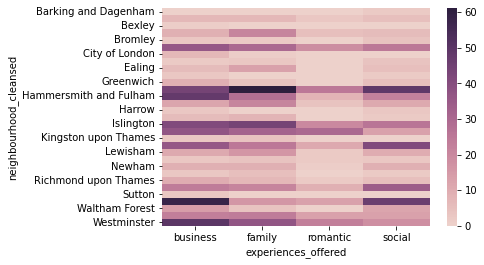

In [28]:
g = sns.heatmap(data = df6_pivot,
                cmap = sns.cubehelix_palette(as_cmap = True))
plt.rcParams["figure.figsize"] = (10, 8)

Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

Необходимые для составления запроса столбцы:

- `room_type` – тип сдаваемого жилья (доступные варианты: `Entire home/apt`, `Private room`, `Hotel room`, `Shared room`)
- `price` – цена за ночь 
- `experiences_offered` – вид доступного впечатления (оставить не `'none'`)

In [29]:
query7 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
ORDER BY
    id ASC
"""
df7 = ph.read_clickhouse(query7, connection = connection)
df7

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [30]:
df7['price_log'] = df7['price'].apply(lambda x: np.log(x))
df7

,room_type,price,price_log
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806662
4,Private room,25.0,3.218876
...,...,...,...
1543,Entire home/apt,100.0,4.605170
1544,Entire home/apt,125.0,4.828314
1545,Entire home/apt,185.0,5.220356
1546,Entire home/apt,110.0,4.700480


/home/user/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


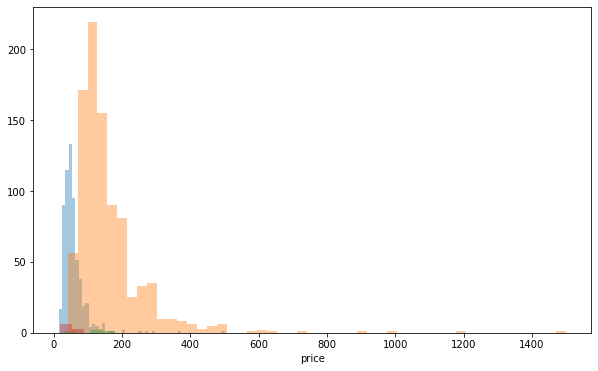

In [31]:
plt.rcParams["figure.figsize"] = (10, 6)
for room in df7.room_type.unique():
    values = df7.price[df7.room_type == room]
    sns.distplot(values, hist = True, kde = False)

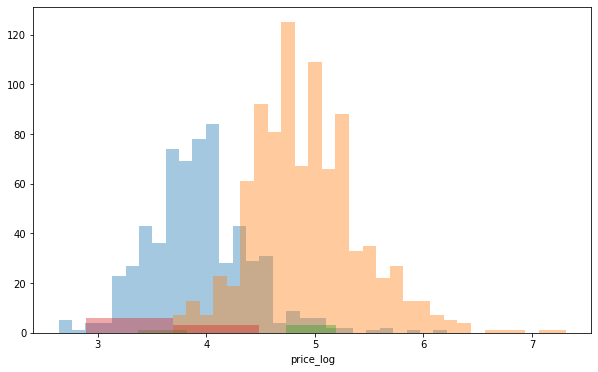

In [32]:
for room in df7.room_type.unique():
    values = df7.price_log[df7.room_type == room]
    sns.distplot(values, hist = True, kde = False)

А это без distplot...

<AxesSubplot:xlabel='price', ylabel='Count'>

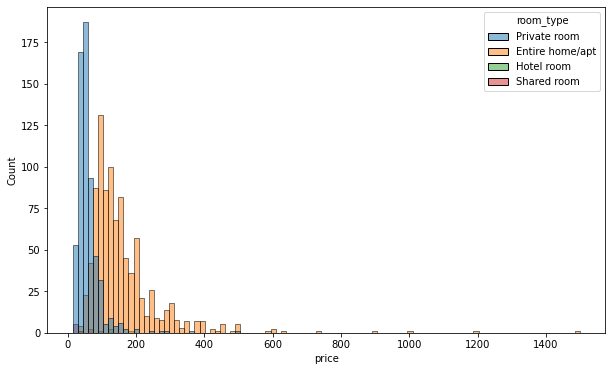

In [33]:
sns.histplot(df7, x = 'price', hue = 'room_type', bins = 100)

<AxesSubplot:xlabel='price_log', ylabel='Count'>

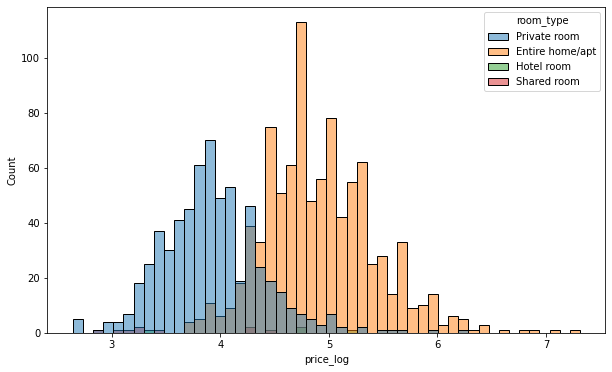

In [34]:
sns.histplot(df7, x = 'price_log', hue = 'room_type', bins = 50)

Немножко экспериментов с функцией ```melt```

In [35]:
df7_for_graph = pd.melt(df7, id_vars = ['room_type'], value_vars = ['price', 'price_log'])
df7_for_graph

,room_type,variable,value
0,Private room,price,65.000000
1,Entire home/apt,price,100.000000
2,Private room,price,150.000000
3,Private room,price,45.000000
4,Private room,price,25.000000
...,...,...,...
3091,Entire home/apt,price_log,4.605170
3092,Entire home/apt,price_log,4.828314
3093,Entire home/apt,price_log,5.220356
3094,Entire home/apt,price_log,4.700480


Выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- ```room_type``` – тип сдаваемого жилья (доступные варианты: ```Entire home/apt```, ```Private room```, ```Hotel room```, ```Shared room```)
- ```price``` – цена за ночь
- ```first_review``` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставим на 1000 строк. Посмотрим как изменялась средняя цена по годам.

In [36]:
query8 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM
    ldn_listings
WHERE
    first_review > '2010-01-01'
ORDER BY
    id ASC
LIMIT 1000
"""
df8 = ph.read_clickhouse(query8, connection = connection)
df8

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [37]:
df8.dtypes

room_type        object
price           float32
first_review     object
dtype: object

In [38]:
df8.first_review = pd.to_datetime(df8.first_review)

In [39]:
df8.dtypes

room_type               object
price                  float32
first_review    datetime64[ns]
dtype: object

In [40]:
df8.first_review[0].year

2010

In [41]:
df8['year'] = df8.first_review.dt.year

In [42]:
df8_averaging_prices = \
    df8 \
    .groupby(['room_type', 'year'], as_index = False) \
    .agg({'price': 'mean'}) \
    .rename(columns = {'price': 'avg_price'})
df8_averaging_prices

,room_type,year,avg_price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


<AxesSubplot:xlabel='year', ylabel='avg_price'>

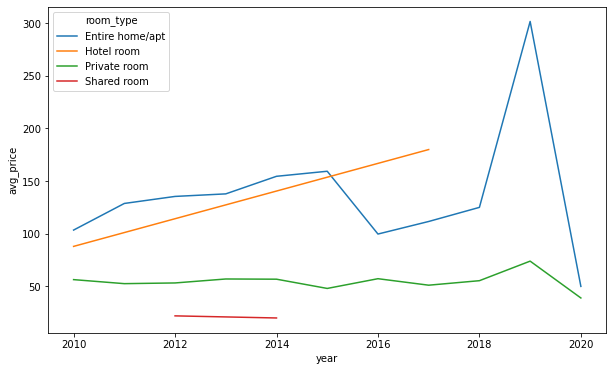

In [43]:
sns.lineplot(data = df8_averaging_prices, x = 'year', y = 'avg_price', hue = 'room_type')